# VAE

https://arxiv.org/pdf/1606.05908   
https://youtu.be/IXsA5Rpp25w?si=YNwOxKtaJtffSOD5   
https://youtu.be/nKM9875PVtU?si=XJsw17goF0WN_Iav   


## Background

### Introduction 

**Latent Variable Models**

We have some $X$ examples distributed according to some unknown distribution $P_{gt}(X)$ and our goal is to learn a model $P$ which can then be used to approximate the unknown distribution $P_{gt}(X)$ through a latent space. Now $P$ needs to learn the complicated dependancies between the dimensions. 

Note that these dimensions can be enormous depending on the data and are difficult to learn but if we were to formalize the model $P$ in mathematical terms we will write.

$$\boxed{\large{P(X) = \int P(X \mid z; \theta) P(z) \, dz}}$$

$P(X \mid z; \theta)$ is marginal likelihood of the data, where we integrate over all the $z$.
$X$ is each sample in training set   
$z$ is vector of latent variables that are the dependancies between the dimensions    
$\theta$ is parameter that provides access to the conditional $P(X|z)$ for sampling (NN paramters)    
VAE's maximize $P(X)$ using $z$ (law of total probability)   

Problems:
1) Defining $z$  
    No simple definition but samples of $z$ can be drawn from a simple prior distribution $\mathcal{N}(0, I)$.   
    Learn a function which maps our independant normally distributed $z$ values to whatever latent variables model needs and then map them to $X$.   
    No need to worry about latent structure the model will learn that. $P(X|z; \theta) = \mathcal{N}(f(z;\theta), \sigma^2 * I)$ where $f(z;\theta)$ is neural network.   
    In other words we are using a gaussian distribution to approximate an unknown distribution.
    
2) Integral over $z$ (Maximize the above equation)  
    Find computable formula for $P(X)$, then take gradient of that formula, then optimize $\theta$ (i.e model parameters) using SGD.  
    One method is sample large number of $z$ and then approximate it but the latent space is enormous and it depends on finding good similarity metric.   
    In high-dimensional latent spaces, most sampled $z$ will contribute negligibly to $P(X)$ unless $z$ is close to the values that are likely under $P(X|z)$.      

### **Setting Objective:**   

**Variational Inference**

**Key idea**: Sample values of $z$ that are likely to have produced $X$ and compute $P(X)$ just from those. In simple terms estimate $P(z|X)$.    

Goal - $P(X) = \frac{P(X|z)P(z)}{P(z|X)}$ 

We approximate $P(z|X)$ by learning $Q(z|X)$ that captures the latent variables $z$ that are likely to produce $X$. Space of $z$ under $Q$ will be much smaller than that of prior $P(z)$.
 
How to actually find $P(X|z)$ from $P(z|X) \sim Q(z|X)$? Need to relate $E_{z \sim Q} P(X|z)$ and $P(X)$.  

Let's start with KL divergence between the $P(z|X)$ and $Q(z|X)$ - 

$$\large{\mathcal{D} \left[ Q(z|X) \| P(z|X) \right] = \mathbb{E}_{z \sim Q} \left[ \log \frac{Q(z|X)}{P(z|X)} \right] = \mathbb{E}_{z \sim Q} \left[ \log Q(z|X) - \log P(z|X) \right]}$$

$$\text{... Using Bayes rule get } P(X) \text{ and } P(X|z) \text{ in equation}$$

$$\large{\mathcal{D} \left[ Q(z|X) \| P(z|X) \right] = \mathbb{E}_{z \sim Q} \left[ \log Q(z|X) - \log P(X|z) - \log P(z) \right] + \log P(X) }$$ 

$$ \boxed{\large{\log P(X)  - \mathcal{D} \left[ Q(z|X) \| P(z|X) \right] = \mathbb{E}_{z \sim Q} \left[\log P(X|z) \right] - \mathcal{D} \left[ Q(z|X) \| P(z) \right] }}$$

Here $X$ is fixed and $Q$ can be any distribution not any random distribution but one that maps $X$ to $z$'s. 

$$ \mathcal{D} \left[ Q(z|X) \| P(z|X) \right] \text{ is intractable and is always positive } $$ 

$$\boxed{\large{ \text{ELBO : }\log P(X) \geq \underset{\text{Reconstruction Loss}}{\mathbb{E}_{z \sim Q} \left[\log P(X|z) \right]} - \underset{\text{KL b/w posterior and prior}}{\mathcal{D} \left[ Q(z|X) \| P(z) \right]}}}$$

Core of VAE:   
- Left Side: Keeping the approximation close to the prior (via the KL divergence term)  
    - $P(X)$
        - Maximize proability of data under the model. 

    - $\mathcal{D} \left[ Q(z|X) \| P(z|X) \right]$ 
        - Measures how well $Q(z|X)$ matches the true posterior distribution $P(x|Z)$. 
        - Minimize this. 
        - A high capacity $Q$ model will make this error term small by turning KL to zero.

- Right Side: Accurately reconstructing the data (via the expectation term)
    - $\mathbb{E}_{z \sim Q} \left[\log P(X|z) \right]$ 
        - Represents the expected likelihood of reconstructing the data from the latent varible $z$. 
        - Can be optimized using techniques like SGD.

    - $\mathcal{D} \left[ Q(z|X) \| P(z) \right]$ 
        - Measures how much our chosen distribution $Q(z|X)$ deviates from the prior $P(z)$. 
        - Minimize this to keep the $Q(z|X)$ close to the prior.
        
- Ideal condition : $\log P(X)  = \mathbb{E}_{z \sim Q} \left[\log P(X|z) \right] $

This forms the basis of the VAE, where $Q$ "encodes" the data into a latent space, and $P$ "decodes" it back to reconstruct the data.

### **Optimizing the Objective:**  

$$\large{ \text{ELBO : }\log P(X) \geq \underset{\text{Reconstruction Loss}}{\mathbb{E}_{z \sim Q} \left[\log P(X|z) \right]} - \underset{\text{KL b/w posterior and prior}}{\mathcal{D} \left[ Q(z|X) \| P(z) \right]}}$$

Before SGD on right hand side of equation.  
1) $\large{Q_{\phi}(z|X) = \mathcal{N}(z \mid \mu(X; \phi), \Sigma(X; \phi))}$  
    where $\mu$ and $\Sigma$ are arbitrary deterministic functions parameterized by $\phi$ that can be learned from the data. 

2) $\large{\mathcal{D} \left[ Q_{\phi}(z|X) \| P_{\theta}(z) \right] = \mathcal{D} \left[ \mathcal{N}(z \mid \mu(X; \phi), \Sigma(X; \phi)) \| \mathcal{N}(X; \mu = 0, \Sigma = I) \right]}$:  
    This term is now a KL divergence between two multivariate gaussian distributions. 
    
2) $\large{\mathbb{E}_{z \sim Q_{\phi}} \left[\log \mathbb{E}_{z \sim Q_{\phi}}P(X|z) \right]}$:  
    Take one sample of $z$ and treat $\log P(X|z)$ for that $z$ as an approximation of $\mathbb{E}_{z \sim Q_{\phi}} \left[\log P_{\theta}(X|z) \right]$.   
    Since we are already doing SGD over multiple $X$ sampled from dataset $D$ this would get a good estimate of the term.

The full equation we want to optimize over the data distribution $D$ - 

$$\large{\mathbb{E}_{X \sim D} \left[ \log P_{\theta}(X) \right] \geq \mathbb{E}_{X \sim D} \left[ \mathbb{E}_{z \sim Q_{\phi}} \left[ \log P_{\theta}(X|z) \right] - \mathcal{D} \left[ Q_{\phi}(z|X) \| P(z) \right] \right]}$$

$$\large{ \mathbb{E}_{X \sim D} \left[ \log P_{\theta}(X) \right] \geq \mathbb{E}_{X \sim D} \left[ \mathbb{E}_{z \sim Q_{\phi}} \left[ \log P_{\theta}(X|z) - \log Q_{\phi}(z|X) + \log P_{\theta}(z) \right] \right]}$$

$$\large{ \mathbb{E}_{X \sim D} \left[ \log P_{\theta}(X) \right] \geq \mathbb{E}_{X \sim D} \left[ \mathbb{E}_{z \sim Q_{\phi}} \left[ \underset{\text{Decoder}}{\log P_{\theta}(X,z)} - \underset{\text{Encoder}}{\log Q_{\phi}(z|X)} \right] \right]}$$

To take gradient of this equation- 
1) Move the gradient symbol into the expectation.  

    $\large{ \nabla_{\theta} \mathbb{E}_{X \sim D} \left[ \log P_{\theta}(X) \right] \geq \mathbb{E}_{X \sim D} \left[ \mathbb{E}_{z \sim Q_{\phi}} \left[ \nabla_{\theta} \log P_{\theta}(X,z) - \log Q_{\phi}(z|X) \right] \right]}$

    $\large{ \nabla_{\theta} \mathbb{E}_{X \sim D} \left[ \log P_{\theta}(X) \right] \neq \mathbb{E}_{X \sim D} \left[ \mathbb{E}_{z \sim Q_{\phi}} \left[ \nabla_{\theta} \log P_{\theta}(X,z)\right] \right]} \text{... this is bad as Q dissapeared}$

2) To make VAE's work it is essential that $Q$ should produce codes for $X$ that $P$ can reliably decode.

3) **Reparameterization Trick** 
    $$\large{\mathbb{E}_{z \sim Q_{\phi}} \left[ \log P_{\theta}(X,z) -  \log Q_{\phi}(z|X) \right]}$$
    Applying reparameterization trick to inner expectation over $z \sim Q_{\phi}(z|X)$ which is variational distribution that depends on $\phi$.  
    Express $z$ as deterministic function of a noise variable $\epsilon$ that is independant of $\phi$  

    1) If $Q_{\phi}(z|X)$ is gaussian then we can express $z$ as 
        $$\large{z = \mu_{\phi}(X) + \sigma_{\phi}(X) \cdot \epsilon}$$
        $$\large{\epsilon \sim \mathcal{N}(0, I)}$$
        $$\large{\mu_{\phi}(X), \sigma_{\phi}(X) \text{ mean and sd of } Q_{\phi}(z|X) \text{ parameterized by } \phi}$$

    2) Replacing $Z$:  
        Instead of sampling $z$ directly from $Q_{\phi}(z|X)$ we express it as a deterministic function of $\epsilon$  
        This transforms expectation over  $z \sim Q_{\phi}$ to expectation over $\epsilon \sim \mathcal{N}(0,I)$

        $$\large{\mathbb{E}_{\epsilon \sim \mathcal{N}(0,I)} \left[ \log P_{\theta}(X,g_{\phi}(\epsilon, X)) - \log Q_{\phi}(g_{\phi}(\epsilon, X)|X) \right]}$$
        $$ \large{g_{\phi}(\epsilon, X) = \mu_{\phi}(X) + \sigma_{\phi}(X) \cdot \epsilon}$$
    
4) Final ELBO: 
    $$\large{\mathbb{E}_{X \sim D} \left[ \log P_{\theta}(X) \right] \geq \mathbb{E}_{X \sim D} \left[ \mathbb{E}_{\epsilon \sim \mathcal{N}(0, I)} \left[ \log P_{\theta}(X, g_{\phi}(\epsilon, X)) - \log Q_{\phi}(g_{\phi}(\epsilon, X) | X) \right] \right]}$$

5) Gradient of ELBO:

$$\large{\nabla_{\epsilon} \mathbb{E}_{X \sim D} \left[ \mathbb{E}_{\epsilon \sim \mathcal{N}(0, I)} \left[ \log P_{\theta}(X, g_{\phi}(\epsilon, X)) - \log Q_{\phi}(g_{\phi}(\epsilon, X) | X) \right] \right]}$$

$$\large{\text{Let } f(\epsilon, X) = \log P_{\theta}(X, g_{\phi}(\epsilon, X)) - \log Q_{\phi}(g_{\phi}(\epsilon, X) | X)}$$

$$\large{\mathbb{E}_{X \sim D} \left[ \mathbb{E}_{\epsilon \sim \mathcal{N}(0, I)} \left[ \nabla_{\epsilon} f(\epsilon, X) \right] \right]}$$

$$\large{\nabla_{\epsilon} f(\epsilon, X) = \nabla_{\epsilon} \left( \log P_{\theta}(X, g_{\phi}(\epsilon, X)) - \log Q_{\phi}(g_{\phi}(\epsilon, X) | X) \right)}$$

$$\large{\nabla_{\epsilon} f(\epsilon, X) = \nabla_z \log P_{\theta}(X, z) \cdot \nabla_{\epsilon} g_{\phi}(\epsilon, X) - \nabla_z \log Q_{\phi}(z | X) \cdot \nabla_{\epsilon} g_{\phi}(\epsilon, X)}$$

$$\large{\text{where } z = g_{\phi}(\epsilon, X)}$$

$$\large{\nabla_{\epsilon} f(\epsilon, X) = \left( \nabla_z \log P_{\theta}(X, z) - \nabla_z \log Q_{\phi}(z | X) \right) \cdot \nabla_{\epsilon} g_{\phi}(\epsilon, X)}$$

$$\boxed{\large{\mathbb{E}_{X \sim D} \left[ \mathbb{E}_{\epsilon \sim \mathcal{N}(0, I)} \left[ \left( \nabla_z \log P_{\theta}(X, z) - \nabla_z \log Q_{\phi}(z | X) \right) \cdot \nabla_{\epsilon} g_{\phi}(\epsilon, X) \right] \right]
}}$$

Here the gradient flows from reconstruction term and the variational term both

## Implementation

### Setup

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
from tqdm import tqdm
from openTSNE import TSNE
import os
from torchviz import make_dot

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

Image Shape: torch.Size([32, 1, 28, 28])


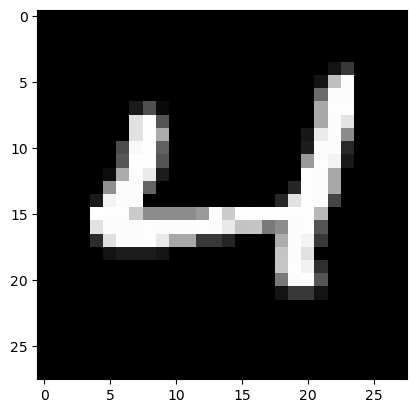

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

# Move the entire dataset to GPU
train_images = train_set.data.unsqueeze(1).float().to(device)  # Add channel dimension and convert to float
train_images = (train_images / 255 - 0.1307) / 0.3081  # Apply normalization manually
train_labels = train_set.targets.to(device)

test_images = test_set.data.unsqueeze(1).float().to(device)
test_images = (test_images / 255 - 0.1307) / 0.3081
test_labels = test_set.targets.to(device)

# Create a new TensorDataset with the data now on the GPU
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(f'Image Shape: {images.shape}')
# plot one image sample from the dataset
plt.imshow(images[0].cpu().numpy().squeeze(), cmap='gray')
plt.show()

### Encoder $Q_{\phi}(z|X) = \mathcal{N}(z \mid \mu(X; \phi), \Sigma(X; \phi))$

In [133]:
class Encoder(nn.Module):
    def __init__(self, z_dim=64):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)   
        self.fc_mu = nn.Linear(2048, z_dim)
        self.fc_log_var = nn.Linear(2048, z_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var
    
test_encoder = Encoder().to(device)
print(test_encoder)

z_test = test_encoder(images)
print(f'mu: {z_test[0].shape}')
print(f'log_var: {z_test[1].shape}')

Encoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc_mu): Linear(in_features=2048, out_features=64, bias=True)
  (fc_log_var): Linear(in_features=2048, out_features=64, bias=True)
)
mu: torch.Size([32, 64])
log_var: torch.Size([32, 64])


### Decoder $P_{\theta}(X|z) = \mathcal{N}(0,I)$

In [149]:
class Decoder(nn.Module):
    def __init__(self, z_dim=64):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(z_dim, 1024)
        self.deconv1 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, 1, 5, stride=2, padding=1, output_padding=3)

    def forward(self, x):
        x = F.relu(self.fc(x))
        x = x.view(x.size(0), 256, 2, 2)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = torch.sigmoid(self.deconv4(x))
        return x
    
test_decoder = Decoder().to(device)
print(test_decoder)

std = torch.exp(0.5*z_test[1])
eps = torch.randn_like(std) 
z_sample = z_test[0] + eps * std

x_hat_test = test_decoder(z_sample)
print(x_hat_test.shape)

Decoder(
  (fc): Linear(in_features=64, out_features=1024, bias=True)
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv4): ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), output_padding=(3, 3))
)
torch.Size([32, 1, 28, 28])


### VAE

#### without reparameterization

VAE_wo_reparam(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=2048, out_features=64, bias=True)
    (fc_log_var): Linear(in_features=2048, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=64, out_features=1024, bias=True)
    (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv4): ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), output_pad

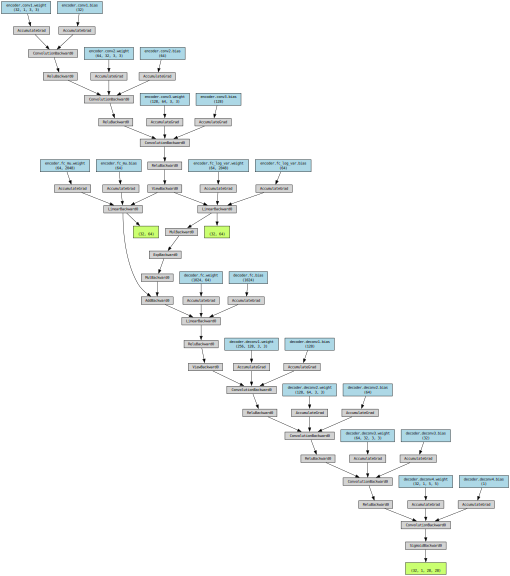

In [150]:
# VAE without reparametrization trick
class VAE_wo_reparam(nn.Module):
    def __init__(self, z_dim=64):
        super(VAE_wo_reparam, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        z = torch.randn_like(mu) * std + mu
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

test_VAE = VAE_wo_reparam().to(device)
print(test_VAE)
print(test_VAE(images)[0].shape)
print(test_VAE(images)[1].shape)
print(test_VAE(images)[2].shape)

graph = make_dot(test_VAE(images), params=dict(test_VAE.named_parameters()))
graph.attr(size="8,8") 
graph.render("vae_model_graph", format="png")
graph

#### with reparameterization

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=2048, out_features=64, bias=True)
    (fc_log_var): Linear(in_features=2048, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=64, out_features=1024, bias=True)
    (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv4): ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), output_padding=(3, 3)

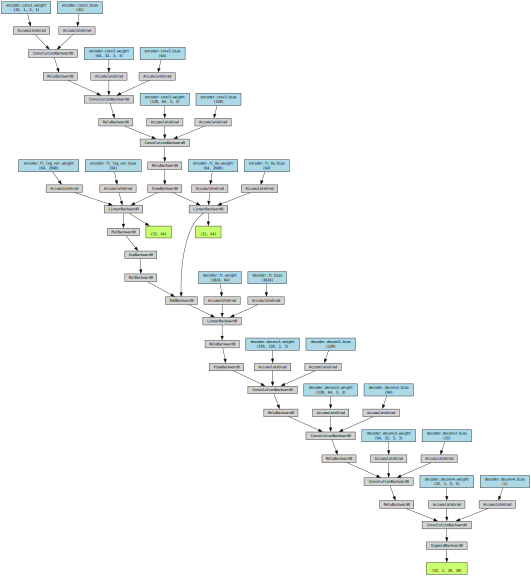

In [152]:
class VAE(nn.Module):
    def __init__(self, z_dim=64):
        super(VAE, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

test_VAE = VAE().to(device)
print(test_VAE)
print(test_VAE(images)[0].shape)
print(test_VAE(images)[1].shape)
print(test_VAE(images)[2].shape)

graph = make_dot(test_VAE(images), params=dict(test_VAE.named_parameters()))
graph.attr(size="8,8") 
graph.render("vae_model_graph", format="png")
graph

### Loss Function  $\text{ELBO : }\log P(X) \geq \underset{\text{Reconstruction Loss}}{\mathbb{E}_{\epsilon \sim \mathcal{N}(0, I)} \left[\log P_{\theta}(X|g_{\phi}(\epsilon, X)) \right]} - \underset{\text{KL}}{\mathcal{D} \left[ Q_{\phi}(z|X) \| \mathcal{N}(0, I) \right]}$

$\large{g_{\phi}(\epsilon, X) = \mu_{\phi}(X) + \sigma_{\phi}(X) \cdot \epsilon}$

In [154]:
def loss_function(x, x_hat, mu, logvar):
    BCE = F.mse_loss(x_hat, x, reduction='sum')
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KL

test_loss = loss_function(images, test_VAE(images)[0], test_VAE(images)[1], test_VAE(images)[2])
print(test_loss)

tensor(33282.1406, device='mps:0', grad_fn=<AddBackward0>)


### Training

In [156]:
def train_loop(model, train_loader, optimizer):
    model.train()
    batch_losses = []
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(data, recon_batch, mu, logvar)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    return batch_losses

def test_loop(model, test_loader):
    model.eval()
    test_loss = []
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            recon_batch, mu, logvar = model(data)
            test_loss.append(loss_function(data, recon_batch, mu, logvar).item())
    return test_loss

Epoch: 0 Train Loss: 16914.909572395834 Test Loss: 29939.104150079616
Epoch: 1 Train Loss: 14429.8804765625 Test Loss: 28416.339800208996
Epoch: 2 Train Loss: 13976.400755729166 Test Loss: 27899.12029135151
Epoch: 3 Train Loss: 13796.615621875 Test Loss: 27674.488383882366
Epoch: 4 Train Loss: 13709.739163020833 Test Loss: 27500.391368307126
Epoch: 5 Train Loss: 13651.794351041666 Test Loss: 27426.990293466362
Epoch: 6 Train Loss: 13615.005547916666 Test Loss: 27393.603002463176
Epoch: 7 Train Loss: 13588.186465625 Test Loss: 27316.73200823547
Epoch: 8 Train Loss: 13564.333103645833 Test Loss: 27284.08377911027
Epoch: 9 Train Loss: 13547.072261458334 Test Loss: 27281.008866814293


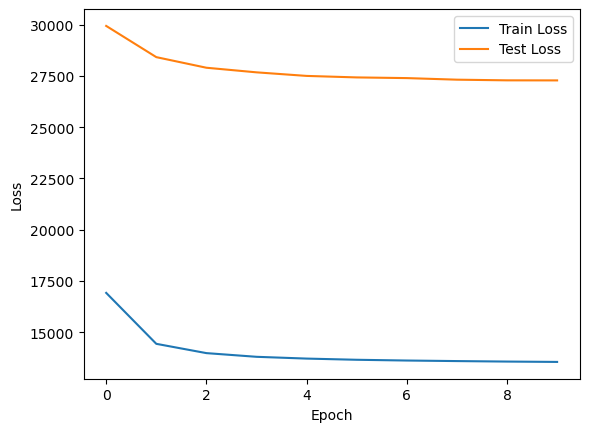

In [158]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
training_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = np.mean(train_loop(model, train_loader, optimizer))
    test_loss = np.mean(test_loop(model, test_loader))
    training_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch: {epoch} Train Loss: {train_loss} Test Loss: {test_loss}')

# plot the training and test losses
plt.plot(training_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

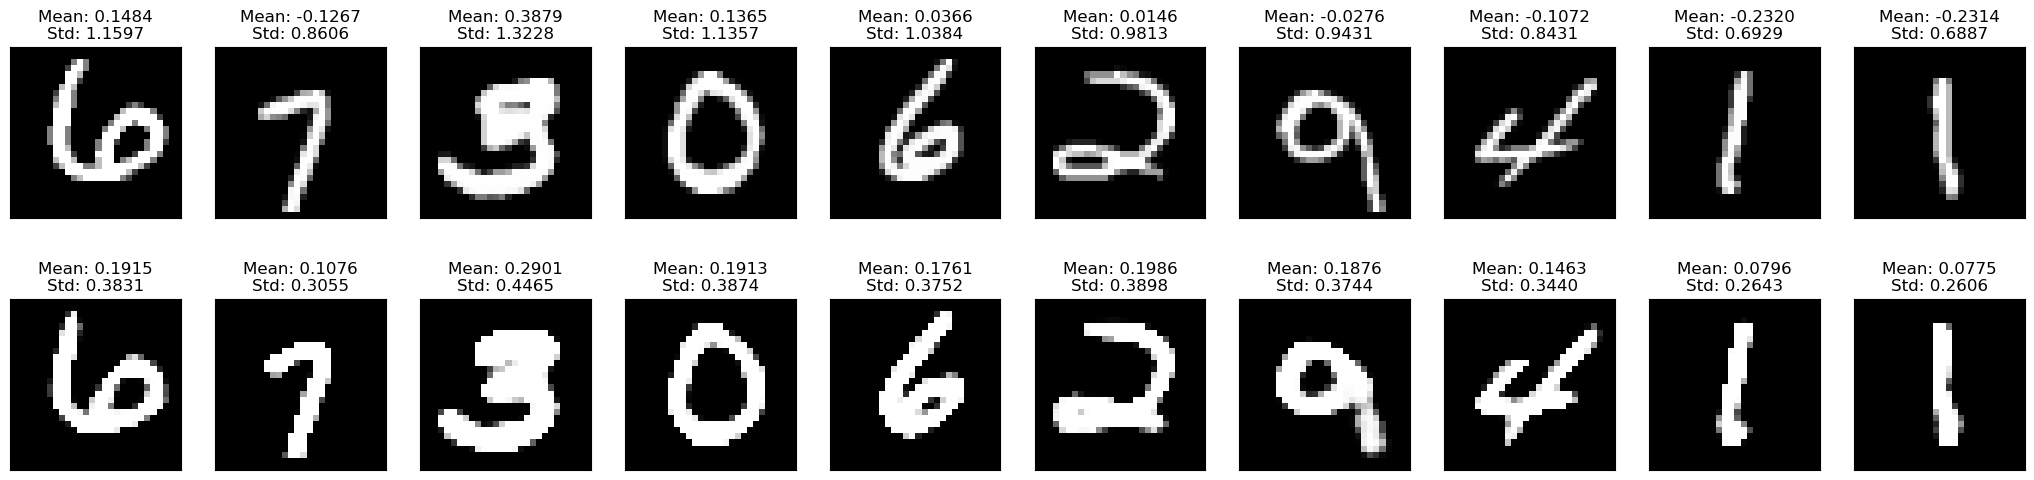

In [160]:
# plot images and their reconstructions
model.eval()

dataiter = iter(train_loader)
images, labels = next(dataiter)

with torch.no_grad():
    reconstructions, mu, logvar = model(images)

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(26, 6))
for images, row in zip([images, reconstructions], axes):
    for img, ax in zip(images, row):
        img_np = img.cpu().detach().view(28, 28).numpy()
        mean = np.mean(img_np)
        std_dev = np.std(img_np)
        ax.imshow(img_np, cmap='gray')
        ax.set_title(f'Mean: {mean:.4f}\nStd: {std_dev:.4f}')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()


### Generate

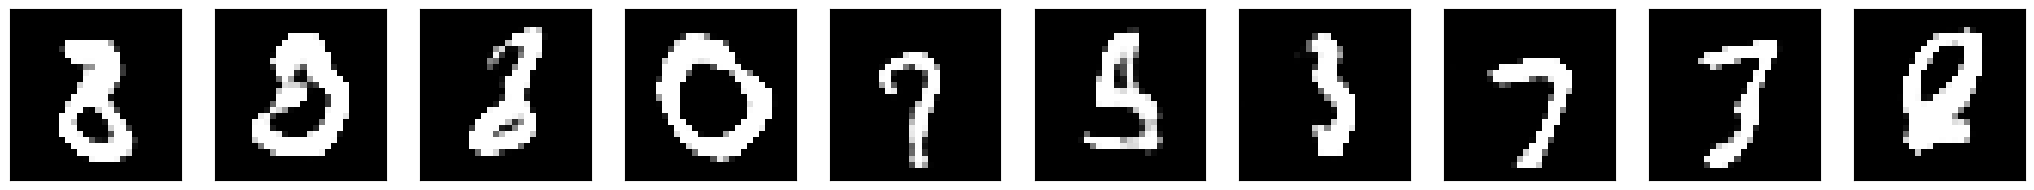

In [172]:
# Generate new images
z = torch.normal(0, 1, size=(10, 64)).to(device)
with torch.no_grad():
    new_images = model.decoder(z)
    new_images = new_images.cpu().detach().view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(26, 4))
for img, ax in zip(new_images, axes):
    ax.imshow(img, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()